In [1]:
import sys
sys.path.append('/home/sharedrive/nafi/traffic/lib/python3.9/site-packages')

import pandas as pd
from chronos import ChronosPipeline
import torch
from table_evaluator import TableEvaluator
import matplotlib.pyplot as plt
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata
import numpy as np
from ctgan import CTGAN
from ctgan import load_demo
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from table_evaluator import TableEvaluator
import pickle
import os
import time
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

In [2]:
itu_train_df = pd.read_csv("./datasets/feature_selected_itu_train.csv")
itu_train_df.head()

,Flow_Duration,Total_Length_of_Bwd_Packets,Bwd_Packet_Length_Max,Bwd_Packet_Length_Mean,Flow_Bytes/s,Flow_Packets/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,...,Fwd_Packets/s,Bwd_Packets/s,Max_Packet_Length,Packet_Length_Mean,Average_Packet_Size,Avg_Bwd_Segment_Size,Subflow_Bwd_Bytes,Init_Win_bytes_forward,min_seg_size_forward,Label
0,68855579.0,11595.0,4344.0,1932.5,1.834710e+02,0.232370,4.590372e+06,1.760000e+07,68300000.0,2.0,...,0.145232,0.087139,4344.0,743.117647,789.562500,1932.5,11595.0,251.0,32.0,DoS_Hulk
1,196.0,174.0,87.0,87.0,1.244898e+06,20408.163270,6.533333e+01,1.079645e+02,190.0,3.0,...,10204.081630,10204.081630,87.0,55.800000,69.750000,87.0,174.0,-1.0,32.0,BENIGN
2,118.0,96.0,48.0,48.0,1.627119e+06,33898.305080,3.933333e+01,6.206717e+01,111.0,3.0,...,16949.152540,16949.152540,48.0,48.000000,60.000000,48.0,96.0,-1.0,20.0,BENIGN
3,295657.0,15841.0,2920.0,1584.1,5.734686e+04,57.499061,1.847856e+04,5.298594e+04,209299.0,1.0,...,23.676084,33.822977,2920.0,941.944444,997.352941,1584.1,15841.0,8192.0,20.0,BENIGN
4,15705351.0,452.0,220.0,90.4,5.469473e+01,0.764071,1.427759e+06,3.221493e+06,9767208.0,82.0,...,0.445708,0.318363,377.0,66.076923,71.583333,90.4,452.0,8192.0,20.0,BENIGN


In [3]:
itu_test_df = pd.read_csv("./datasets/feature_selected_itu_test.csv")
itu_test_df.head()

,Flow_Duration,Total_Length_of_Bwd_Packets,Bwd_Packet_Length_Max,Bwd_Packet_Length_Mean,Flow_Bytes/s,Flow_Packets/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,...,Fwd_Packets/s,Bwd_Packets/s,Max_Packet_Length,Packet_Length_Mean,Average_Packet_Size,Avg_Bwd_Segment_Size,Subflow_Bwd_Bytes,Init_Win_bytes_forward,min_seg_size_forward,Label
0,998.0,0.0,0.0,0.0,0.000000e+00,2004.008016,9.980000e+02,0.000000e+00,998.0,998.0,...,2004.008016,0.000000,0.0,0.0,0.00,0.0,0.0,251.0,32.0,DoS_Hulk
1,63111103.0,0.0,0.0,0.0,0.000000e+00,0.110916,1.050000e+07,1.190000e+07,32100000.0,999612.0,...,0.110916,0.000000,0.0,0.0,0.00,0.0,0.0,29200.0,40.0,DoS_Slowhttptest
2,202.0,130.0,65.0,65.0,1.128713e+06,19801.980200,6.733333e+01,3.348632e+01,106.0,48.0,...,9900.990099,9900.990099,65.0,55.4,69.25,65.0,130.0,-1.0,20.0,BENIGN
3,3.0,0.0,0.0,0.0,0.000000e+00,666666.666700,3.000000e+00,0.000000e+00,3.0,3.0,...,666666.666700,0.000000,0.0,0.0,0.00,0.0,0.0,274.0,32.0,DoS_Hulk
4,37.0,6.0,6.0,6.0,1.621622e+05,54054.054050,3.700000e+01,0.000000e+00,37.0,37.0,...,27027.027030,27027.027030,6.0,2.0,3.00,6.0,6.0,29200.0,40.0,PortScan


In [4]:
itu_train_df.shape, itu_test_df.shape

((1781545, 25), (511540, 25))

In [5]:
label_encoder = LabelEncoder()
scaler = StandardScaler()

In [6]:
small_classes = ['Web_Attack__XSS', 'Web_Attack__Brute_Force',
       'Web_Attack__Sql_Injection', 'Infiltration', 'Heartbleed', 'Bot']

def calculate_emd(real_data, synthetic_data, bins=20):
    emd_scores = {}
    for column in real_data.columns:
        real_hist, bin_edges = np.histogram(real_data[column], bins=bins, density=True)
        synthetic_hist, _ = np.histogram(synthetic_data[column], bins=bin_edges, density=True)
        
        # Avoid division by zero by adding a small value
        real_hist += 1e-8
        synthetic_hist += 1e-8
        
        # Normalize histograms to form probability distributions
        real_prob = real_hist / np.sum(real_hist)
        synthetic_prob = synthetic_hist / np.sum(synthetic_hist)
        
        
        emd_scores[column] = wasserstein_distance(real_prob, synthetic_prob)

    mean_emd = np.mean(list(emd_scores.values()))
    return mean_emd

def calculate_classwise_emd(real_data, synthetic_data):
    emd_store = []
    for cls in small_classes:
        syn = synthetic_data[synthetic_data['Label']==cls].copy()
        real = real_data[real_data['Label']==cls].copy()
        
        syn.drop(columns='Label', inplace=True)
        real.drop(columns='Label', inplace=True)

        emd = calculate_emd(real, syn)
        emd_store.append({cls, emd})
    print("EMD: ", emd_store)
    print(f'Mean: {np.mean([emd for item in emd_store for emd in item if isinstance(emd, (int, float))])}')
    
def calculate_jsd(real_data, synthetic_data, bins=20):
    jsd_scores = {}
    for column in real_data.columns:
        real_hist, bin_edges = np.histogram(real_data[column], bins=bins, density=True)
        synthetic_hist, _ = np.histogram(synthetic_data[column], bins=bins, density=True)
        
        jsd = jensenshannon(real_hist, synthetic_hist)
        
        jsd_scores[column] = jsd

    mean_jsd = np.mean(list(jsd_scores.values()))
    return mean_jsd

def calculate_classwise_jsd(real_data, synthetic_data):
    jsd_store = []
    for cls in small_classes:
        syn = synthetic_data[synthetic_data['Label'] == cls].copy()
        real = real_data[real_data['Label'] == cls].copy()
        
        syn.drop(columns='Label', inplace=True)
        real.drop(columns='Label', inplace=True)

        jsd = calculate_jsd(real, syn)
        jsd_store.append({cls, jsd}) 
    
    print("JSD: ", jsd_store)
    # Extract JSD values from the sets and compute the mean
    jsd_values = [val for item in jsd_store for val in item if isinstance(val, (int, float))]
    print(f'Mean JSD: {np.mean(jsd_values)}')

In [7]:
def generate_data_for_classes_ctgan(df, classes, num_samples, num_epochs=500):
    synthetic_data = pd.DataFrame()
    for cls in classes:
        selected_df = df[df["Label"] == cls]
        ctgan = CTGAN(epochs=num_epochs, verbose=True)
        ctgan.fit(selected_df, list(selected_df.columns))
        samples = ctgan.sample(num_samples)
        
        synthetic_data = pd.concat([synthetic_data, samples])
    return synthetic_data

In [17]:
def save_label_encoder(le, file_name):
    with open(f'./models/{file_name}_label_encoder.pkl', 'wb') as le_file:
        pickle.dump(label_encoder, le_file)

def save_scaler(scaler, file_name):
    with open(f'./models/{file_name}_scaler.pkl', 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)
        
def pick_web_classes(synthetic_data_df):
    selected_data = pd.DataFrame()
    labels_to_keep = ["Web_Attack__XSS", "Web_Attack__Brute_Force", "Web_Attack__Sql_Injection"]
    for label in labels_to_keep:
        filtered_new_data = synthetic_data_df[synthetic_data_df["Label"] == label]
        selected_data = pd.concat([selected_data, filtered_new_data], ignore_index=True)
        
    return selected_data
    
def ctgan_train(train_df, epochi, file_name, reduced_test_df, rounds=0, info=None):
    for num_sample in [1000]:
        print(f"{file_name} epoch={epochi} samples={num_sample} round={rounds}")

        synthetic_file_path = f"./datasets/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.csv"
        
        if os.path.exists(synthetic_file_path):
            print(f"Synthetic data already exists: {synthetic_file_path}")
            synthetic_data_df = pd.read_csv(synthetic_file_path)
        else:
            start_time = time.time()
            print("Generating synthetic data...") 
            synthetic_data = generate_data_for_classes_ctgan(train_df, small_classes, num_sample, epochi)

            # save and load synthetic data
            synthetic_data.to_csv(f'./datasets/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.csv', index=False)
            synthetic_data_df = pd.read_csv(synthetic_file_path)
            
            elapsed_time = time.time() - start_time
            print(f"Execution time for generating data: {elapsed_time:.2f} seconds")
        
        calculate_classwise_emd(train_df, synthetic_data_df)
        calculate_classwise_jsd(train_df, synthetic_data_df)
        synthetic_data_df = pick_web_classes(synthetic_data_df)
        

        # combine synthetic and real data
        combined_train_synth_df = pd.concat([train_df, synthetic_data_df], axis=0, ignore_index=True)

        # divide to x_train and y_train from reduced_train_df
        x_train = combined_train_synth_df.drop(columns=["Label"])
        y_train = combined_train_synth_df["Label"]
        x_test = reduced_test_df.drop(columns=["Label"])
        y_test = reduced_test_df["Label"]
        
        y_train = label_encoder.fit_transform(y_train) # Encode string labels into numeric format
        y_test = label_encoder.transform(y_test)
        x_train = scaler.fit_transform(x_train) # Standardize the features
        x_test = scaler.transform(x_test)
        save_label_encoder(label_encoder, file_name)
        save_scaler(scaler, file_name)

        RF_model = RandomForestClassifier(random_state=1002, verbose=2)
        RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

        pred_rf = RF_model.predict(x_test)


        pickle.dump(RF_model, open(f'./models/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}{info}.pkl', 'wb'))

        print(f"Classification Report for Sample Size {num_sample}:")
        print(classification_report(y_test, pred_rf, digits=4, target_names=label_encoder.classes_))

        table_evaluator = TableEvaluator(train_df, synthetic_data_df)
        print(table_evaluator.visual_evaluation())

In [101]:
ctgan_train(train_df=itu_train_df, epochi=1500, file_name='synthetic_from_itu_ctgan', reduced_test_df=itu_test_df, rounds=1, info="3Classes")

synthetic_from_itu_ctgan epoch=1500 samples=1000 round=1
Synthetic data already exists: ./datasets/synthetic_from_itu_ctgansample1000epoch1500rounds1.csv
EMD:  [{0.014822065015103263, 'Web_Attack__XSS'}, {0.015288622166396211, 'Web_Attack__Brute_Force'}, {'Web_Attack__Sql_Injection', 0.008938832280555946}, {0.003151041453545594, 'Infiltration'}, {'Heartbleed', 0.001776295472820645}, {0.0069089954251647405, 'Bot'}]
Mean: 0.008480975302264401
JSD:  [{0.17956178894711292, 'Web_Attack__XSS'}, {0.18837005557261544, 'Web_Attack__Brute_Force'}, {0.07422343077728681, 'Web_Attack__Sql_Injection'}, {0.03931810982538283, 'Infiltration'}, {'Heartbleed', 0.01515014030143654}, {0.09534184433896321, 'Bot'}]
Mean JSD: 0.0986608949604663
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  3.5min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.0s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9993    0.9991    0.9992    410865
                      Bot     0.8046    0.6864    0.7409       354
                     DDoS     0.9998    0.9993    0.9995     23160
            DoS_GoldenEye     0.9962    0.9925    0.9943      1861
                 DoS_Hulk     0.9980    0.9978    0.9979     41626
         DoS_Slowhttptest     0.9431    0.9839    0.9631       994
            DoS_slowloris     0.9924    0.9971    0.9948      1048
              FTP-Patator     1.0000    0.9972    0.9986      1436
               Heartbleed     1.0000    0.5000    0.6667         2
             Infiltration     1.0000    0.3333    0.5000         6
                 PortScan     0.9940    0.9995    0.9968     28728
              SSH-Patator     0.9981    0.9897    0.9939      1067
  Web_Attack__Brute_Force     0.7561    0.7978    0.7764       272
Web_Attack__Sql_I

In [102]:
ctgan_train(train_df=itu_train_df, epochi=1500, file_name='synthetic_from_itu_ctgan', reduced_test_df=itu_test_df, rounds=2, info="3Classes")

synthetic_from_itu_ctgan epoch=1500 samples=1000 round=2
Synthetic data already exists: ./datasets/synthetic_from_itu_ctgansample1000epoch1500rounds2.csv
EMD:  [{0.01436218207802295, 'Web_Attack__XSS'}, {0.01571115437989791, 'Web_Attack__Brute_Force'}, {0.009331049151442644, 'Web_Attack__Sql_Injection'}, {0.0036085402080983926, 'Infiltration'}, {'Heartbleed', 0.0019761878455711273}, {0.006787273065576756, 'Bot'}]
Mean: 0.00862939778810163
JSD:  [{0.1735641267290333, 'Web_Attack__XSS'}, {0.20727929451239194, 'Web_Attack__Brute_Force'}, {0.07619661371563331, 'Web_Attack__Sql_Injection'}, {0.04427049494965163, 'Infiltration'}, {0.016499945047166155, 'Heartbleed'}, {0.12340457581423192, 'Bot'}]
Mean JSD: 0.10686917512801804
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 1

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  3.4min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.0s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9993    0.9991    0.9992    410865
                      Bot     0.8053    0.6893    0.7428       354
                     DDoS     0.9998    0.9993    0.9995     23160
            DoS_GoldenEye     0.9957    0.9919    0.9938      1861
                 DoS_Hulk     0.9978    0.9978    0.9978     41626
         DoS_Slowhttptest     0.9432    0.9849    0.9636       994
            DoS_slowloris     0.9933    0.9971    0.9952      1048
              FTP-Patator     1.0000    0.9972    0.9986      1436
               Heartbleed     1.0000    1.0000    1.0000         2
             Infiltration     1.0000    0.3333    0.5000         6
                 PortScan     0.9941    0.9996    0.9968     28728
              SSH-Patator     0.9962    0.9925    0.9944      1067
  Web_Attack__Brute_Force     0.7509    0.7868    0.7684       272
Web_Attack__Sql_I

In [103]:
ctgan_train(train_df=itu_train_df, epochi=1500, file_name='synthetic_from_itu_ctgan', reduced_test_df=itu_test_df, rounds=3, info="3Classes")

synthetic_from_itu_ctgan epoch=1500 samples=1000 round=3
Synthetic data already exists: ./datasets/synthetic_from_itu_ctgansample1000epoch1500rounds3.csv
EMD:  [{0.015536098395251547, 'Web_Attack__XSS'}, {0.015910458961345155, 'Web_Attack__Brute_Force'}, {'Web_Attack__Sql_Injection', 0.008379417720685093}, {0.003997109360903546, 'Infiltration'}, {'Heartbleed', 0.0016283893342571947}, {0.006970672172023716, 'Bot'}]
Mean: 0.00873702432407771
JSD:  [{0.1891702717816213, 'Web_Attack__XSS'}, {0.18723261660115828, 'Web_Attack__Brute_Force'}, {0.07231224585507884, 'Web_Attack__Sql_Injection'}, {0.04661040769265481, 'Infiltration'}, {0.013744888729721343, 'Heartbleed'}, {0.09939058798950202, 'Bot'}]
Mean JSD: 0.1014101697749561
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 1

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  3.3min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.0s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9993    0.9991    0.9992    410865
                      Bot     0.8119    0.6949    0.7489       354
                     DDoS     0.9997    0.9993    0.9995     23160
            DoS_GoldenEye     0.9952    0.9936    0.9944      1861
                 DoS_Hulk     0.9978    0.9978    0.9978     41626
         DoS_Slowhttptest     0.9431    0.9839    0.9631       994
            DoS_slowloris     0.9933    0.9971    0.9952      1048
              FTP-Patator     1.0000    0.9979    0.9990      1436
               Heartbleed     1.0000    1.0000    1.0000         2
             Infiltration     1.0000    0.3333    0.5000         6
                 PortScan     0.9940    0.9996    0.9968     28728
              SSH-Patator     0.9981    0.9934    0.9958      1067
  Web_Attack__Brute_Force     0.7448    0.7941    0.7687       272
Web_Attack__Sql_I

In [9]:
def count_negative_values(df):
    """
    Analyzes each feature in the DataFrame and outputs the number of negative values along with the values themselves.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame to analyze.
    
    Returns:
    None
    """
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            # Calculate negative values
            negative_mask = df[column] < 0
            negative_count = negative_mask.sum()
            negative_values = df[column][negative_mask].tolist()
            
            # Print results for the current feature
            print(f"Feature: {column}")
            print(f"Number of negative values: {negative_count}")
            print(f"Negative values: {negative_values}\n")
        else:
            print(f"Feature: {column} is non-numeric. Skipping.\n")

In [10]:
count_negative_values(itu_test_df)

Feature: Flow_Duration
Number of negative values: 25
Negative values: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -12.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]

Feature: Total_Length_of_Bwd_Packets
Number of negative values: 0
Negative values: []

Feature: Bwd_Packet_Length_Max
Number of negative values: 0
Negative values: []

Feature: Bwd_Packet_Length_Mean
Number of negative values: 0
Negative values: []

Feature: Flow_Bytes/s
Number of negative values: 17
Negative values: [-12000000.0, -6000000.0, -12000000.0, -12000000.0, -8000000.0, -12000000.0, -12000000.0, -6000000.0, -6000000.0, -12000000.0, -666666.6667, -12000000.0, -12000000.0, -12000000.0, -6000000.0, -12000000.0, -12000000.0]

Feature: Flow_Packets/s
Number of negative values: 25
Negative values: [-2000000.0, -2000000.0, -2000000.0, -2000000.0, -2000000.0, -2000000.0, -2000000.0, -2000000.0, -2000000.0, -2000000.0, -2000000.0, -2000000.0, -2000000.0, -2000000.0,

In [11]:
import pandas as pd
from tqdm import tqdm

def analyze_negative_values(df, show_values=False, sample=10):
    """
    Analyzes numeric columns in a DataFrame for negative values, optimized for large datasets.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame.
    show_values (bool): If True, show sample of negative values (default: False).
    sample (int): Number of sample values to display (if show_values=True).
    
    Returns:
    pd.DataFrame: Summary of negative counts per column.
    """
    # Select only numeric columns to optimize processing
    numeric_cols = df.select_dtypes(include=['number']).columns
    summary = []
    
    # Use tqdm for progress bar (only in Jupyter)
    for col in tqdm(numeric_cols, desc="Processing columns"):
        negative_count = (df[col] < 0).sum()
        result = {"Feature": col, "Negative Count": negative_count}
        
        if show_values and negative_count > 0:
            negatives = df[col][df[col] < 0]
            result["Sample Values"] = negatives.head(sample).tolist()
        
        summary.append(result)
    
    return pd.DataFrame(summary)

analyze_negative_values(itu_train_df)

Processing columns: 100%|██████████████████████| 24/24 [00:00<00:00, 482.19it/s]


,Feature,Negative Count
0,Flow_Duration,67
1,Total_Length_of_Bwd_Packets,0
2,Bwd_Packet_Length_Max,0
3,Bwd_Packet_Length_Mean,0
4,Flow_Bytes/s,52
5,Flow_Packets/s,67
6,Flow_IAT_Mean,67
7,Flow_IAT_Std,0
8,Flow_IAT_Max,67
9,Flow_IAT_Min,1870


In [12]:
analyze_negative_values(itu_test_df)

Processing columns: 100%|██████████████████████| 24/24 [00:00<00:00, 680.93it/s]


,Feature,Negative Count
0,Flow_Duration,25
1,Total_Length_of_Bwd_Packets,0
2,Bwd_Packet_Length_Max,0
3,Bwd_Packet_Length_Mean,0
4,Flow_Bytes/s,17
5,Flow_Packets/s,25
6,Flow_IAT_Mean,25
7,Flow_IAT_Std,0
8,Flow_IAT_Max,25
9,Flow_IAT_Min,493


In [13]:
itu_train_df = itu_train_df.drop(columns=['Init_Win_bytes_forward', 'Flow_IAT_Min'])
itu_test_df = itu_test_df.drop(columns=['Init_Win_bytes_forward', 'Flow_IAT_Min'])

In [14]:
def replace_negatives_with_positive_mean(df):
    df_copy = df.copy()
    
    for col in df_copy.columns:
        if col == "Label":
            continue
        if pd.api.types.is_numeric_dtype(df_copy[col]):
            # calculate the mean of positive values in the column
            positive_values = df_copy[col][df_copy[col] >= 0]
            if not positive_values.empty:
                positive_mean = positive_values.mean()
                # replace negatives with the mean of positive values
                df_copy.loc[df_copy[col] < 0, col] = positive_mean
            else:
                print(f"Column '{col}' has no positive values. Negatives remain unchanged.")
    
    return df_copy

In [15]:
itu_train_df = replace_negatives_with_positive_mean(itu_train_df)
itu_test_df = replace_negatives_with_positive_mean(itu_test_df)

In [16]:
analyze_negative_values(itu_train_df)

Processing columns: 100%|██████████████████████| 22/22 [00:00<00:00, 490.91it/s]


,Feature,Negative Count
0,Flow_Duration,0
1,Total_Length_of_Bwd_Packets,0
2,Bwd_Packet_Length_Max,0
3,Bwd_Packet_Length_Mean,0
4,Flow_Bytes/s,0
5,Flow_Packets/s,0
6,Flow_IAT_Mean,0
7,Flow_IAT_Std,0
8,Flow_IAT_Max,0
9,Fwd_IAT_Total,0


synthetic_from_itu_ctgan_after_neg_removed epoch=1500 samples=1000 round=1
Synthetic data already exists: ./datasets/synthetic_from_itu_ctgan_after_neg_removedsample1000epoch1500rounds1.csv
EMD:  [{'Web_Attack__XSS', 0.01713333096789302}, {0.019451709875402377, 'Web_Attack__Brute_Force'}, {'Web_Attack__Sql_Injection', 0.010424129126744069}, {'Infiltration', 0.0026757035035371297}, {0.0023153535720504765, 'Heartbleed'}, {0.007171017647507442, 'Bot'}]
Mean: 0.00986187411552242
JSD:  [{'Web_Attack__XSS', 0.2063581959280798}, {0.2553823770903593, 'Web_Attack__Brute_Force'}, {'Web_Attack__Sql_Injection', 0.08651772439764902}, {0.03360977672393132, 'Infiltration'}, {0.020953789443641683, 'Heartbleed'}, {0.11475786149883511, 'Bot'}]
Mean JSD: 0.11959662084708271
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
bui

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  3.6min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.1s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9955    0.9902    0.9928    410865
                      Bot     0.8048    0.4774    0.5993       354
                     DDoS     0.9986    0.9991    0.9988     23160
            DoS_GoldenEye     0.9780    0.9785    0.9782      1861
                 DoS_Hulk     0.9168    0.9762    0.9455     41626
         DoS_Slowhttptest     0.9441    0.9859    0.9646       994
            DoS_slowloris     0.9933    0.9971    0.9952      1048
              FTP-Patator     0.9944    0.9868    0.9906      1436
               Heartbleed     1.0000    1.0000    1.0000         2
             Infiltration     1.0000    0.3333    0.5000         6
                 PortScan     0.9939    0.9996    0.9967     28728
              SSH-Patator     0.9943    0.4902    0.6566      1067
  Web_Attack__Brute_Force     0.7297    0.6949    0.7119       272
Web_Attack__Sql_I

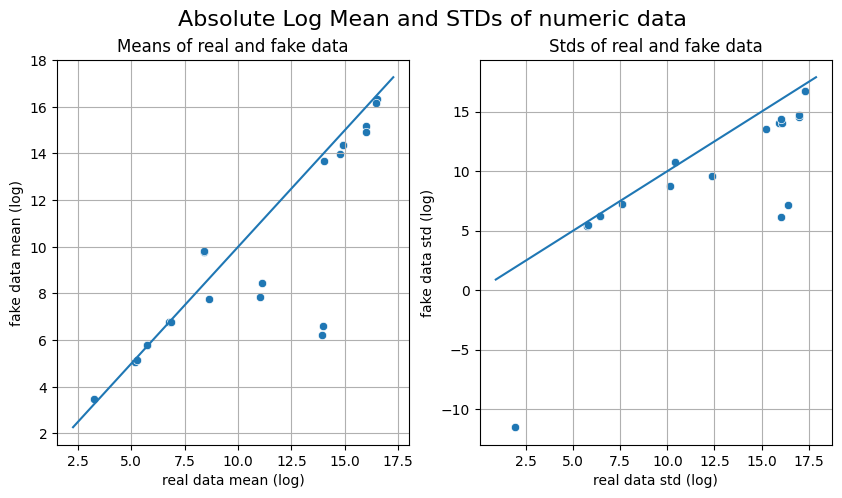

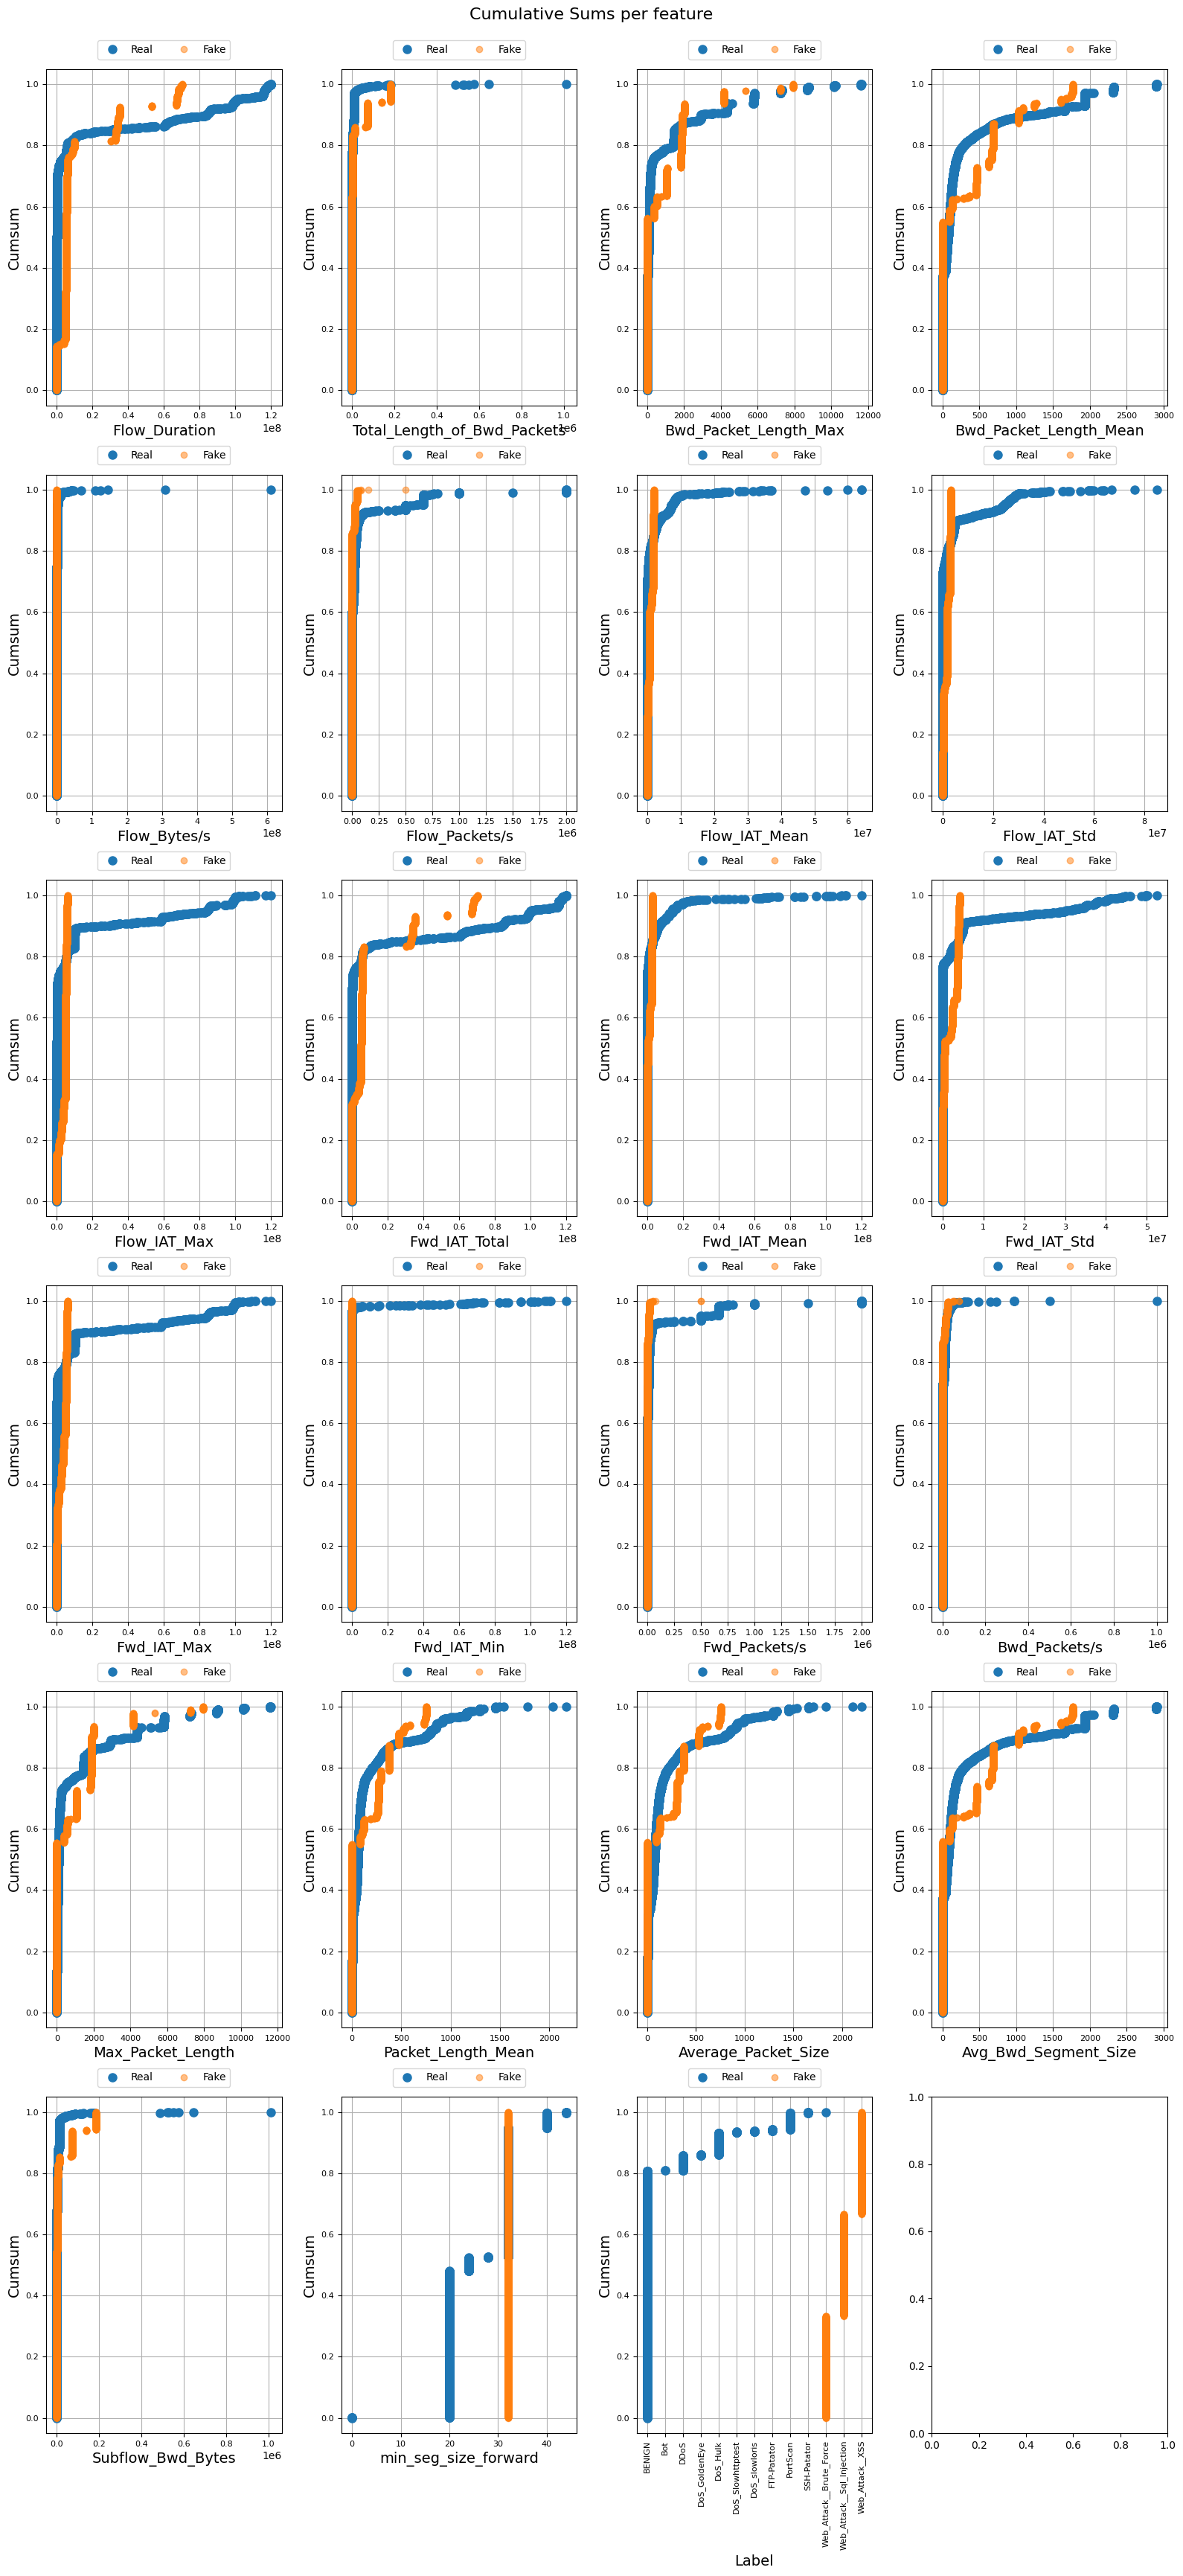

/home/nafi/.local/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')


In [ ]:
ctgan_train(train_df=itu_train_df, epochi=1500, file_name='synthetic_from_itu_ctgan_after_neg_removed', reduced_test_df=itu_test_df, rounds=1)

In [59]:
itu_train_df["Label"].value_counts()

Label
BENIGN                       1430936
DoS_Hulk                      144976
PortScan                      100036
DDoS                           80655
DoS_GoldenEye                   6484
FTP-Patator                     4998
SSH-Patator                     3714
DoS_slowloris                   3651
DoS_Slowhttptest                3464
Bot                             1232
Web_Attack__Brute_Force          949
Web_Attack__XSS                  410
Infiltration                      22
Web_Attack__Sql_Injection         12
Heartbleed                         6
Name: count, dtype: int64

In [60]:
itu_test_df["Label"].value_counts()

Label
BENIGN                       410865
DoS_Hulk                      41626
PortScan                      28728
DDoS                          23160
DoS_GoldenEye                  1861
FTP-Patator                    1436
SSH-Patator                    1067
DoS_slowloris                  1048
DoS_Slowhttptest                994
Bot                             354
Web_Attack__Brute_Force         272
Web_Attack__XSS                 117
Infiltration                      6
Web_Attack__Sql_Injection         4
Heartbleed                        2
Name: count, dtype: int64

In [6]:
itu_train_df.shape

(1781545, 25)